In [2]:
import os
import collections
import random
import math
import click
import numpy as np
import tensorflow as tf
from six.moves import xrange
import mlflow
from scipy.spatial import distance
from scipy.stats import kurtosis, skew
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
# mlflow.create_experiment('Model')
model_experiment = 1
# mlflow.create_experiment('Returns')
returns_experiment = 2 

In [ ]:
class Word2Vec:
    def __init__(self,filename
                 , batch_size=128
                 , skip_window=1
                 , num_skips=2
                 , embedding_size = 128
                 , num_sampled = 64
                 , num_steps = 100001
                ):
        self.filename = filename
        self.vocabulary_size = None
        self.data_index = 0
        self.batch_size = batch_size
        self.skip_window = skip_window
        self.num_skips = num_skips
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.num_steps = num_steps
        self.valid_size = 16
        self.valid_window = 100
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)
        self.min_loss = 99999999999
        self.best_embeddings = None

    def run(self):
        self.load_vocabulary()
        self.build_dataset()
        self.build_model()
        self.train_model()

    def load_vocabulary(self):
        self.vocabulary = []
        f = open(self.filename, 'r')
        for l in f.readlines():
            for r in l.split(" "):
                if r.strip() == "":
                    continue
                self.vocabulary.append(r)
        f.close()
        print('Success: Loaded Vocabulary.')
        print('Vocabulary size :', len(self.vocabulary))

    def build_dataset(self):
        k = []
        k.extend(collections.Counter(self.vocabulary).most_common(len(set(self.vocabulary))))
        count = [['UNK', -1]]
        for x in k:
            if x[1] >= 1:
                count.append(x)
        self.vocabulary_size = math.floor(len(count))
        dictionary = {}
        for word, _ in count:
            dictionary[word] = len(dictionary)
        data = []
        unk_count = 0
        for word in self.vocabulary:
            index = dictionary.get(word, 0)
            if index == 0:
                unk_count += 1
            data.append(index)
        count[0][1] = unk_count
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        self.data = data
        self.count = count
        self.unused_dictionary = dictionary
        self.reverse_dictionary = reverse_dictionary
        print('Success: Built Dataset.')

    def generate_batch(self):
        assert self.batch_size % self.num_skips == 0
        assert self.num_skips <= 2 * self.skip_window
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        span = 2 * self.skip_window + 1
        buffer = collections.deque(maxlen=span)
        if self.data_index + span > len(self.data):
            self.data_index = 0
        buffer.extend(self.data[self.data_index:self.data_index + span])
        self.data_index += span
        for i in range(self.batch_size // self.num_skips):
            context_words = []
            for w in range(0, span):
#             for w in range(skip_window + 1, span):
                if w == self.skip_window:
                    continue
                context_words.append(w)
            words_to_use = random.sample(context_words, self.num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * self.num_skips + j] = buffer[self.skip_window]
                labels[i * self.num_skips + j, 0] = buffer[context_word]
            if self.data_index == len(self.data):
                buffer.extend(self.data[0:span])
                self.data_index = span
            else:
                buffer.append(self.data[self.data_index])
                self.data_index += 1
        self.data_index = (self.data_index + len(self.data) - span) % len(self.data)
        return batch, labels

    def build_model(self):
        graph = tf.Graph()
        with graph.as_default():
            # Input data.
            with tf.name_scope('inputs'):
                self.train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
                self.train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
                valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32)
            with tf.device('/cpu:0'):
                with tf.name_scope('embeddings'):
                    embeddings = tf.Variable(tf.random_normal([self.vocabulary_size, self.embedding_size], -10, 10))
                    embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
                with tf.name_scope('weights'):
                    nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size], stddev=1.0 / math.sqrt(self.embedding_size)))
                with tf.name_scope('biases'):
                    nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                                     labels=self.train_labels, inputs=embed,
                                                     num_sampled=self.num_sampled, num_classes=self.vocabulary_size))
                # Add losses here to make the component distributions assymetric.
                # Penalize for point not being on unit circle.
#                 unit_loss = tf.Variable(0.0)
#                 for i in range(len(self.reverse_dictionary)):
#                     total = tf.Variable(0.0)
#                     for j in range(self.embedding_size):
#                         total = total + (embeddings[i][j] ** 2)
#                     unit_loss = unit_loss + tf.abs(1 - tf.sqrt(total))
#                 self.loss = self.loss + (unit_loss / 1e64)
                # Penalize for mean of the respective axis not being as desired.
#                 self.loss = self.loss + tf.abs(tf.reduce_mean(embeddings[:, 0]))
#                 self.loss = self.loss + tf.abs(tf.reduce_mean(embeddings[:, 1]))
                
            with tf.name_scope('optimizer'):
                self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
            self.normalized_embeddings = embeddings / norm
            valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings, valid_dataset)
            self.similarity = tf.matmul(valid_embeddings, self.normalized_embeddings, transpose_b=True)
            init = tf.global_variables_initializer()
        self.graph = graph
        self.init = init
        print('Success: Built Model.')

    def train_model(self):
        self.log_to_mlflow()
        try:
            with tf.Session(graph=self.graph) as session:
                self.init.run()
                print('Initialized Model Parameters.')
                average_loss = 0
                for step in xrange(self.num_steps):
                    batch_inputs, batch_labels = self.generate_batch()
                    feed_dict = {self.train_inputs: batch_inputs, self.train_labels: batch_labels}
                    _, loss_val = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
                    mlflow.log_metric('step', step)
                    mlflow.log_metric('loss', loss_val)
                    average_loss += loss_val
                    if step % 2000 == 0:
                        if step > 0:
                            average_loss /= 2000
                        print('Average loss at step ', step, ': ', average_loss)
                        average_loss = 0
                    self.final_embeddings = self.normalized_embeddings.eval()
                    if loss_val <= self.min_loss:
                        self.min_loss = loss_val
                        print('Min Loss :', self.min_loss)
                        mlflow.log_metric('min_loss', self.min_loss)
                        self.best_embeddings = self.final_embeddings
            print('Success: Trained Model.')
        finally:
            self.save_and_log_embeddings()
            self.compute_distances()

    def visualize(self, filename='tsne.png'):
        def plot_with_labels(low_dim_embs, labels, filename):
            assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
            plt.figure(figsize=(18, 18))  # in inches
            for i, label in enumerate(labels):
                x, y = low_dim_embs[i, :]
                plt.scatter(x, y)
                plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            plt.savefig(filename)
            plt.show()
        try:
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=300, method='exact')
            plot_only = min(100000, len(set(self.reverse_dictionary)))
            low_dim_embs = tsne.fit_transform(self.best_embeddings[:plot_only, :])
            labels = [str(round(float(model.reverse_dictionary[i]), 3)) for i in xrange(1, plot_only+1)]
            plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), filename))
            with mlflow.start_run(experiment_id=0):
                mlflow.log_artifact(filename)
        except ImportError as ex:
            print('Please install sklearn, matplotlib, and scipy to show embeddings.')
            print(ex)
            
    def save_and_log_embeddings(self):
        classes_filename = 'output_classes.txt'
        embeddings_filename = 'output_embeddings.txt'
        classes = open(classes_filename, 'w')
        embeddings = open(embeddings_filename, 'w')
        for key in self.reverse_dictionary:
            classes.write(str(self.reverse_dictionary[key]) + '\n')
            embeddings.write(' '.join(map(str, self.best_embeddings[key])) + '\n')
        classes.close()
        embeddings.close()
        mlflow.log_artifact(classes_filename)
        mlflow.log_artifact(embeddings_filename)
        print('Success: Saved Embeddings.')
            
    def log_to_mlflow(self):
        mlflow.log_artifact(self.filename)
        mlflow.log_param('vocabulary_size', self.vocabulary_size)
        mlflow.log_param('batch_size', self.batch_size)
        mlflow.log_param('skip_window', self.skip_window)
        mlflow.log_param('num_skips', self.num_skips)
        mlflow.log_param('embedding_size', self.embedding_size)
        mlflow.log_param('num_sampled', self.num_sampled)
        mlflow.log_param('num_steps', self.num_steps)
    
    def compute_distances(self):
        self.distances = distance.cdist(self.best_embeddings, self.best_embeddings, 'euclidean')
        print('Success: Computed Distances.')
 

In [ ]:
# ticker = 'NSE:INFY'
ticker = 'AAPL'
# ticker = 'GOOGL'
print(ticker)
filename = ticker + '_returns_train.txt'
# filename = ticker + '_returns_test.txt'
# filename = 'random.txt'
# filename = 'vocabulary_snp_returns.txt'
# Hyperparameters
embedding_size = 2
# # Use these in production.
skip_window=1
num_skips=2
# vocabulary_size is the number of tokens with frquency greater than 1.
batch_size=128
num_sampled = 32

In [ ]:
num_steps = 100001
model = Word2Vec(filename, batch_size, skip_window, num_skips, embedding_size, num_sampled, num_steps)
with mlflow.start_run(experiment_id=model_experiment):
    model.run()

In [ ]:
model.visualize()

In [4]:
def load_classes_and_embeddings(classes_filename='output_classes.txt', embeddings_filename='output_embeddings.txt'):
    fd = {}
    rd = {}
    f = open(classes_filename, 'r')
    i = 0
    for l in f.readlines():
        v = l.split()[0]
        if v == 'UNK':
            rd[i] = 'UNK'
            fd[v] = i
        else:
            rd[i] = float(v)
            fd[float(v)] = i
        i += 1
    f.close()
    vectors = []
    f = open(embeddings_filename, 'r')

    for l in f.readlines():
        p = []
        for v in l.split():
            p.append(float(v))
        vectors.append(p)
    return fd, rd, np.array(vectors)

fd, rd, vectors = load_classes_and_embeddings()

In [ ]:
vectors[:, 0].mean(), vectors[:, 1].mean()

In [5]:
d = []
dx = []
dy = []
for i in range(vectors.shape[0]):
    x = vectors[i][0]
    y = vectors[i][1]
    dx.append(x)
    dy.append(y)
    d.append(math.sqrt(x **2 + y ** 2))
x_mean = np.array(dx).mean()
y_mean = np.array(dy).mean()
print(x_mean, y_mean, math.sqrt(x_mean ** 2 + y_mean ** 2), math.sqrt(0.5 ** 2 + 0.5 ** 2))
print(np.array(d).mean(), np.array(d).std(), np.array(d).max(), np.array(d).min())
print(np.array(dx).mean(), np.array(dx).std(), np.array(dx).max(), np.array(dx).min())
print(np.array(dy).mean(), np.array(dy).std(), np.array(dy).max(), np.array(dy).min())

-0.5125997246408281 -0.5362688601151829 0.7418509068748859 0.7071067811865476
0.9999999892572622 5.252856280418402e-08 1.000000124149817 0.9999998032527256
-0.5125997246408281 0.48018063367587893 0.5043053 -0.9999986
-0.5362688601151829 0.4680638519754204 0.80814004 -0.99999964


In [ ]:
vec = []
for i in range(len(model.best_embeddings)):
    x1 = model.best_embeddings[i][0]
    y1 = model.best_embeddings[i][1]
    theta = math.tanh(y1 / x1)
    if model.reverse_dictionary[i] == 'UNK':
        x2 = x1
        y2 = y1
    else:
        x2 = x1 + float(model.reverse_dictionary[i]) * math.sin(theta)
        y2 = y1 + float(model.reverse_dictionary[i]) * math.cos(theta)
#         if float(model.reverse_dictionary[i]) > 0:
#             x2 = x1 + float(model.reverse_dictionary[i]) * math.sin(theta) * 10
#             y2 = y1 + float(model.reverse_dictionary[i]) * math.cos(theta) * 10
#         else:
#             x2 = x1 - float(model.reverse_dictionary[i]) * math.sin(theta) * 10
#             y2 = y1 - float(model.reverse_dictionary[i]) * math.cos(theta) * 10
    vec.append([x2, y2])
vec = np.array(vec)

In [ ]:
import matplotlib.pyplot as plt
filename = 'tsne.png'
k = 10000
ddx = []
ddy = []
plt.figure(figsize=(4, 4))
for i in range(k):
    v = vectors[fd[test_returns[i]]]
    x, y = v
    ddx.append(x)
    ddy.append(y)
    plt.scatter(x, y)
    if i == k - 1:
#         print(round(train_returns[i], 4))
        plt.annotate(round(test_returns[i], 4), xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        x, y = np.array(ddx).mean(), np.array(ddy).mean()
        cur_mean = math.sqrt((x - x_mean)**2 + (y - y_mean)**2)
        cur_x_mean = x - x_mean
        cur_y_mean = y - y_mean
        print(cur_mean, prev_mean, cur_mean - prev_mean)
        print(cur_x_mean, prev_x_mean, 1 - cur_x_mean / prev_x_mean)
        print(cur_y_mean, prev_y_mean, 1 - cur_y_mean / prev_y_mean)
        prev_mean = cur_mean
        prev_x_mean = cur_x_mean
        prev_y_mean = cur_y_mean
        plt.scatter(x, y)
        plt.annotate('m', xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        x, y = 0, 0
        plt.scatter(x_mean, y_mean)
        plt.annotate('o', xy=(x_mean, y_mean), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()
k

In [ ]:
# Observation: There could only be a maximum of 10% change to current mean of x and y.
# And we know that x and y should be closed under [-1, 1] and should be unit distance away from origin.
# And it seems if the sample size is pretty large, the change is going to be even less small.

In [ ]:
k = 2
x, y = vectors[:k, 0].mean(), vectors[:k, 1].mean()

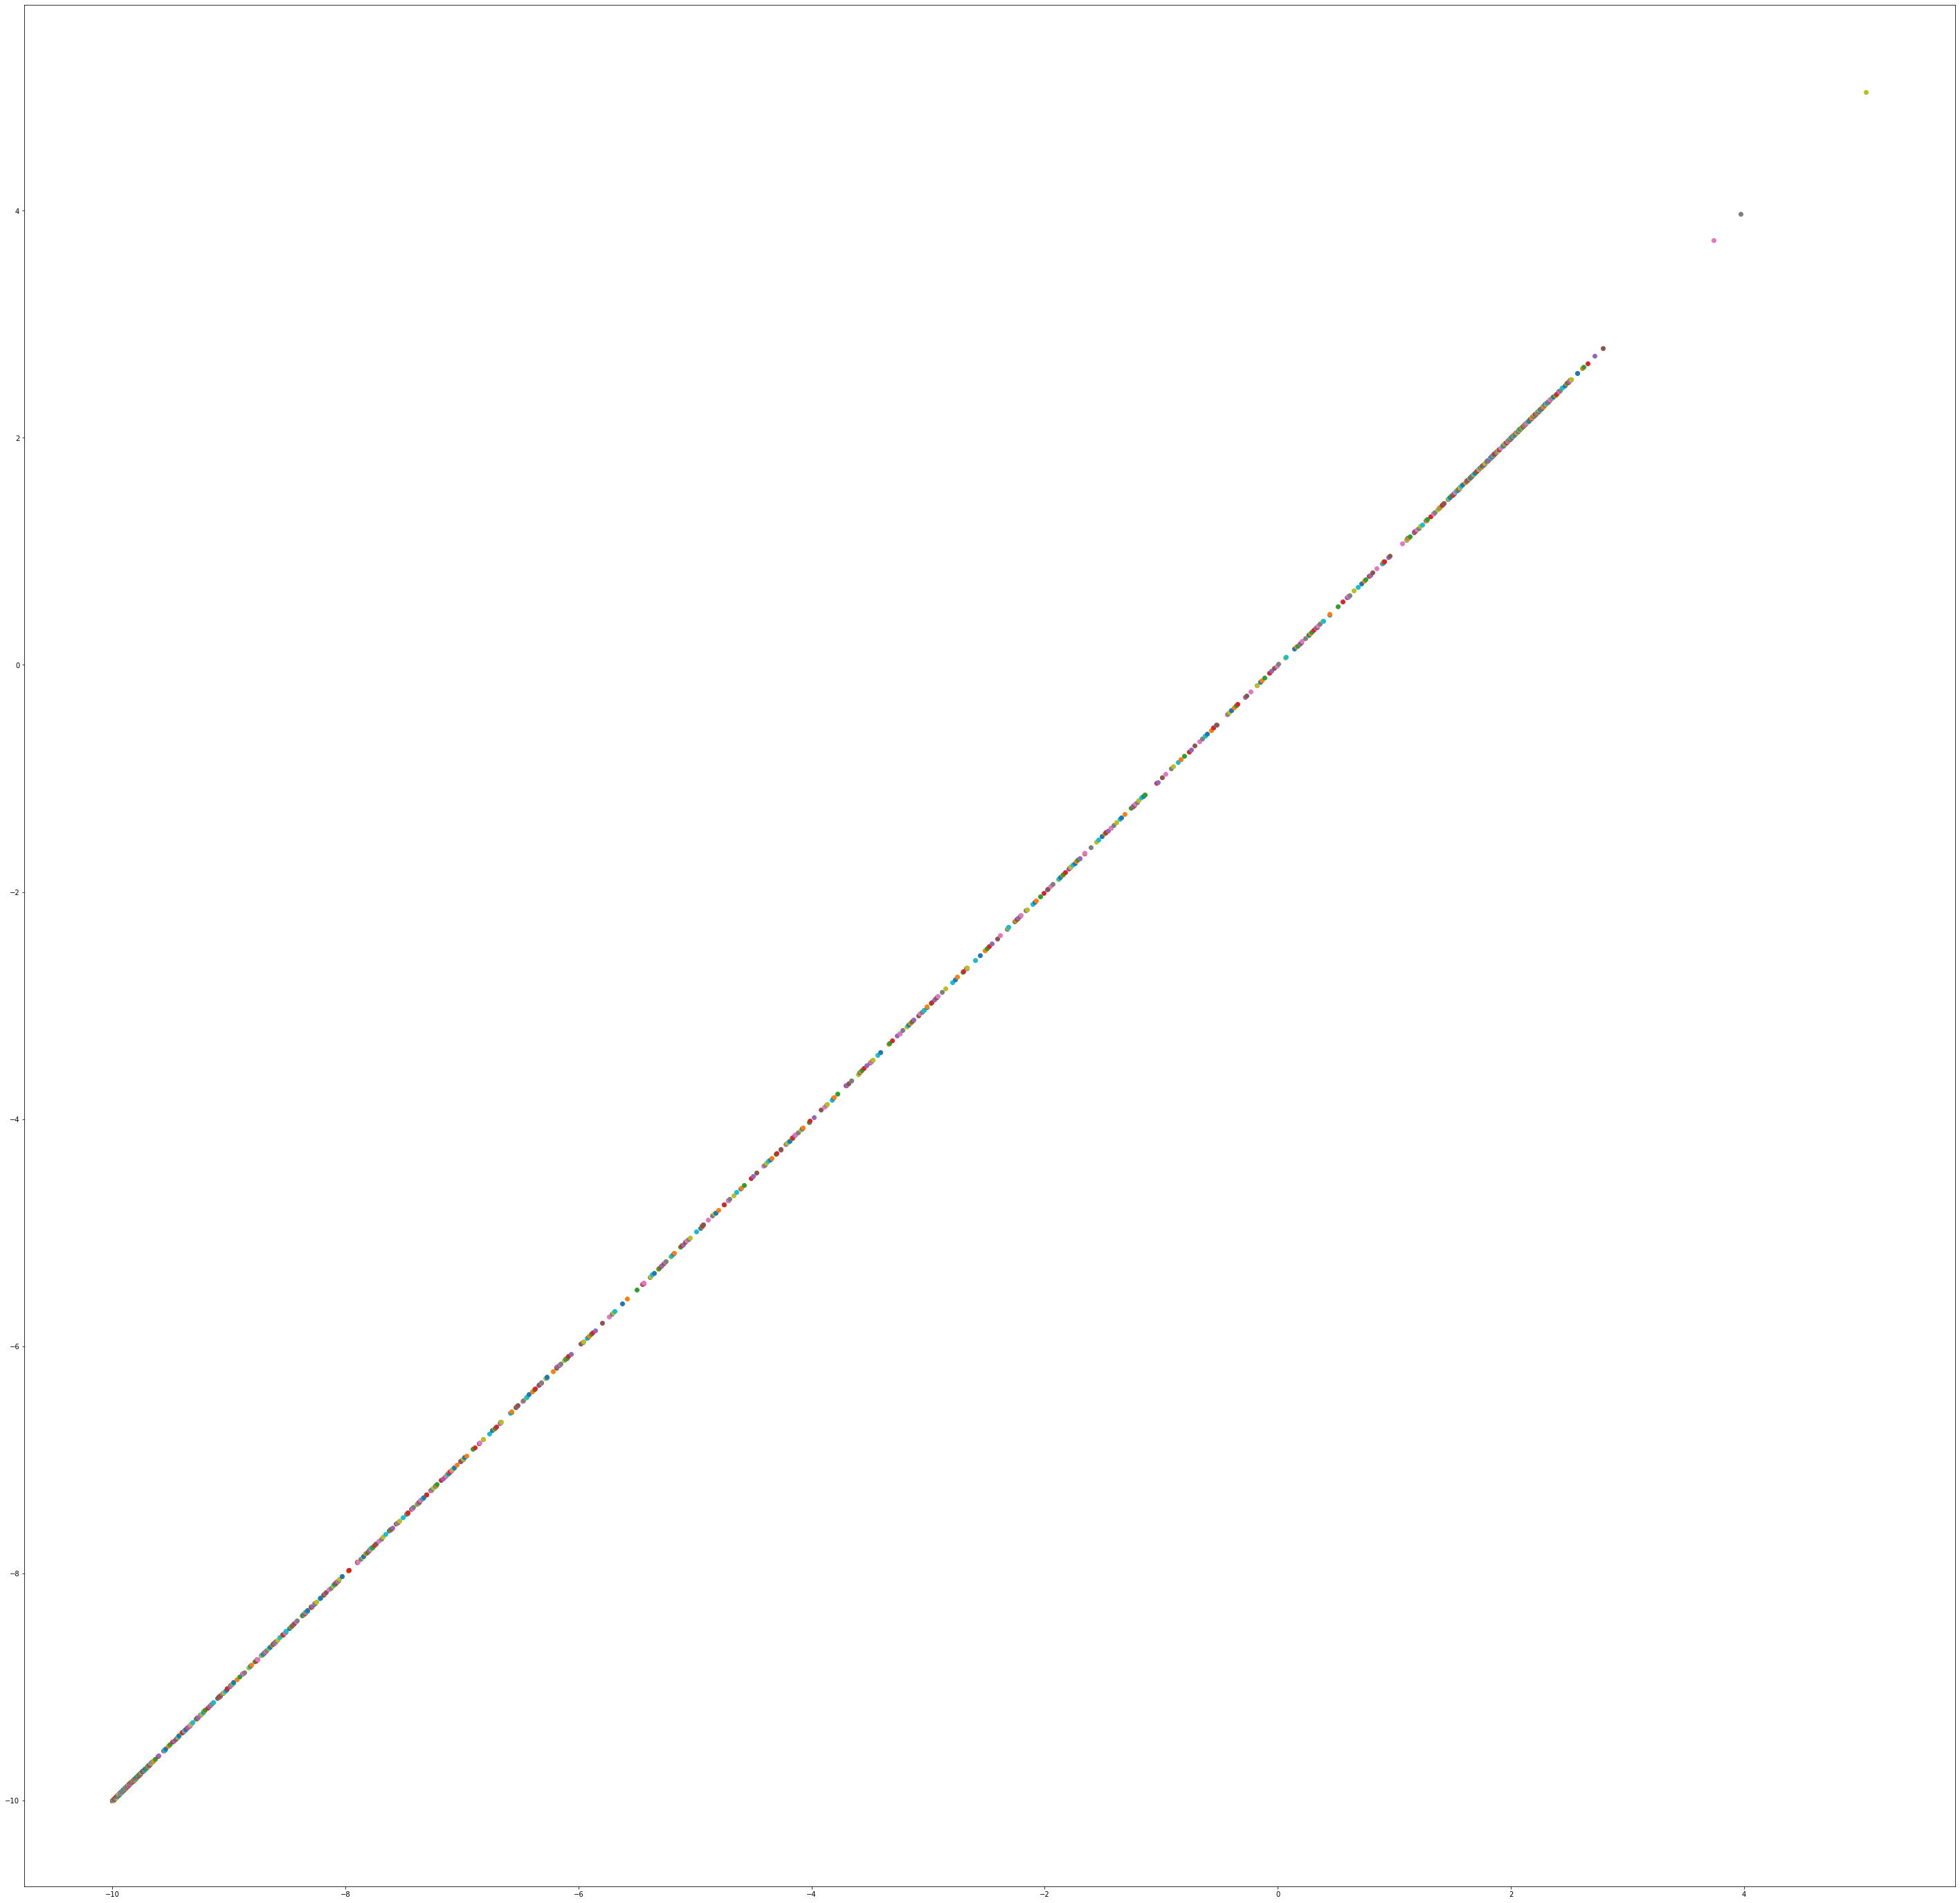

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 50))
for x in sorted(dx):
    plt.scatter(x, x)
plt.show()
plt.savefig(filename)

1448


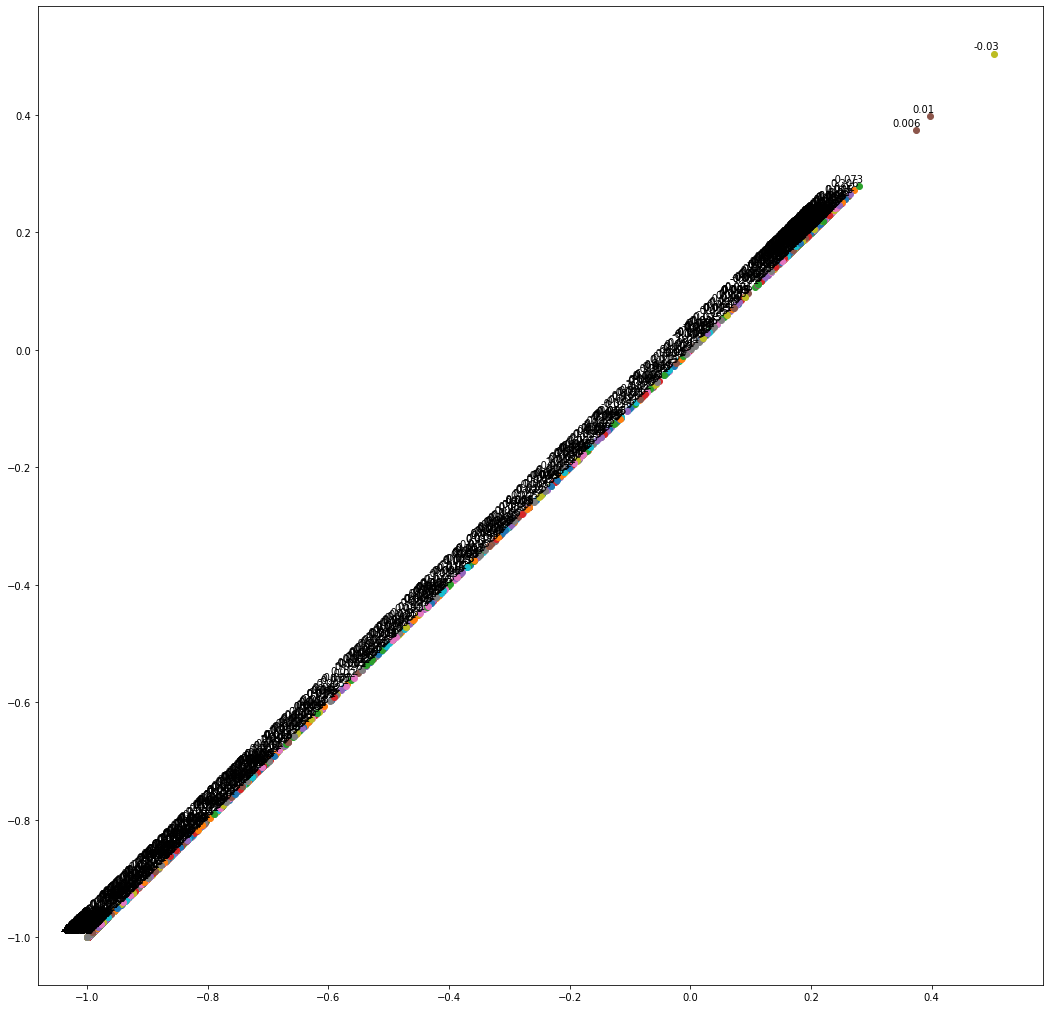

In [14]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, x)
        plt.annotate(label, xy=(x, x), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.savefig(filename)
    plt.show()
try:
    filename = 'tsne.png'
    import matplotlib.pyplot as plt
    plot_only = min(4000, len(set(rd)))
    low_dim_embs = vectors[:plot_only, :]
    labels = [str(round(float(rd[i]), 3)) for i in xrange(1, plot_only)]
    print(len(labels))
    plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), filename))
    with mlflow.start_run(experiment_id=0):
        mlflow.log_artifact(filename)
except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [ ]:
len(model.reverse_dictionary)

In [ ]:
i = 77
vec[i], vectors[i], model.reverse_dictionary[i]
math.sqrt(vec[i][0] ** 2 + vec[i][1] ** 2) - math.sqrt(vectors[i][0] ** 2 + vectors[i][1] ** 2), model.reverse_dictionary[i]

In [ ]:
vectors[:, 0]

In [12]:
z = figure(plot_width=1000, plot_height=350)
z.line(dx, dy, line_color="pink")
show(z)

In [ ]:
mean_dist = {}
for i in range(vectors.shape[0]):
    x = vectors[i][0]
    y = vectors[i][1]
    dist = math.sqrt((x - x_mean) **2 + (y - y_mean) ** 2)
    mean_dist[i] = dist

sorted_mean_dist = sorted(mean_dist.items(), key=lambda x: x[1], reverse=True)
num_dist = {}
for k, v in sorted_mean_dist:
    num_dist[rd[k]] = v
# num_dist

In [ ]:
x_pos = 0
x_neg = 0
y_pos = 0
y_neg = 0
x_zeroes = 0
y_zeroes = 0
x_pos_sum = 0
x_neg_sum = 0
y_pos_sum = 0
y_neg_sum = 0
for i in range(vectors.shape[0]):
    x = vectors[i][0]
    y = vectors[i][1]
    if rd[i] == 'UNK':
        continue
    num = float(rd[i])
    if x > 0:
        x_pos += 1
        x_pos_sum += abs(num)
    elif x < 0:
        x_neg += 1
        x_neg_sum += abs(num)
    else:
        x_zeroes += 1
    if y > 0:
        y_pos += 1
        y_pos_sum += abs(num)
    elif y < 0:
        y_neg += 1
        y_neg_sum += abs(num)
    else:
        y_zeroes += 1
x_pos, x_neg, x_zeroes, y_pos, y_neg, y_zeroes
x_pos_sum, x_neg_sum, y_pos_sum, y_neg_sum

In [ ]:
# Build two datasets
# Set 1 -> {two parts, one with positive x, one with negative x}
# Set 2 -> {two parts, one with positive y, one with negative y}
# Start experiment (when we already know the center of distribution that will arise)
# Observe a value, find its vector, calculate its x and y.
# Now calculate the mean of the x and y respectively.
# This should converge towards mean of Rayleigh distribution.
# Make the bet such that it confirms to the Rayleigh distribution.
# The more observations and the more something is away from centre, the more sure we can be.
# But how do we mae buy sell decisions?
# We can predict delta x and delta y required to make the distribution rayleigh.
# Now we can select values from this range and observe their mean and make the bet accordingly.

In [ ]:
x_mean = 0
y_mean = 0

In [ ]:
# f = open('AAPL_returns_test.txt', 'r')
f = open('random.txt', 'r')
test_returns = []
for l in f.readlines():
    for r in l.split():
        if r.strip() == '':
            continue
        else:
            test_returns.append(float(r.strip()))
f.close()
f = open('AAPL_returns_train.txt', 'r')
train_returns = []
for l in f.readlines():
    for r in l.split():
        if r.strip() == '':
            continue
        else:
            train_returns.append(float(r.strip()))
f.close()

In [ ]:
len(test_returns), len(set(test_returns)), len(train_returns), len(set(train_returns))

In [ ]:
tt = {}
for i in test_returns:
    min_dist = 999999999999
    num = 999999999999
    for j in train_returns:
        dist = abs(i - j)
        if dist < min_dist:
            min_dist = dist
            num = j
            tt[i] = j

In [ ]:
len(dx)

In [ ]:
xx = set()
yy = set()
step = 0
# returns_list = test_returns
returns_list = train_returns
win, loss, alpha = 0, 0, 0
continous_wins = 0
continous_losses = 0
x_momentum = 0
y_momentum = 0
req_x = 0
req_y = 0
req_x_list = []
req_y_list = []
mode = 0
win_loss_mode = mode
f = open('logs.txt', 'w')
f.close()
with mlflow.start_run(experiment_id=returns_experiment):
    for r in returns_list:
        f = open('logs.txt', 'a')
        try:
            x = vectors[fd[r]][0]
            y = vectors[fd[r]][1]
        except:
            x = vectors[fd[tt[r]]][0]
            y = vectors[fd[tt[r]]][1]
        xx.add(x)
        yy.add(y)
        xx_mean = np.array(list(xx)).mean()
        yy_mean = np.array(list(yy)).mean()
        req_x = (x_mean * (len(xx) + 1) - xx_mean * len(xx))
        req_y = (y_mean * (len(yy) + 1) - yy_mean * len(yy))
        req_x_list.append(req_x)
        req_y_list.append(req_y)
        mean_req_x = np.array(req_x_list[-10:]).mean()
        mean_req_y = np.array(req_y_list[-10:]).mean()
        # Do better estimation.
        dists = {}
        for i in range(len(vectors)):
            # Better to use distance matrix.
            if rd[i] == 'UNK':
                continue
            dists[rd[i]] = math.sqrt((mean_req_x - vectors[i][0]) ** 2 + (mean_req_y - vectors[i][1]) ** 2)
        sorted_dists = sorted(dists.items(), key=lambda x: x[1])
        predictions = []
        for k, v in sorted_dists:
            predictions.append(k)
        prediction = np.array(predictions[:10]).mean()
        if r==returns_list[step] and prediction != 0 and returns_list[step+1] != 0:
            # Be careful while changing signs or you will introduce look-ahead bias.
            # You are allowed to change only this one sign on below variable.
            if continous_losses == 3:
                if mode == 0:
                    mode = 1
                else:
                    mode = 0
            if mode == 0:
                pred = prediction
            else:
                pred = -prediction
            if pred > 0:
                if returns_list[step+1] > 0:
                    win += 1
                    continous_wins += 1
                    continous_losses = 0
                else:
                    loss += 1
                    continous_losses += 1
                    continous_wins = 0
            else:
                if returns_list[step+1] < 0:
                    win += 1
                    continous_wins += 1
                    continous_losses = 0
                else:
                    loss += 1
                    continous_losses += 1
                    continous_wins = 0
        if (win + loss) != 0:
            alpha = win / (win + loss) * 100
#             if alpha > 52:
#                 xx = set()
#                 yy = set()
        ### LOGGING ###
        mlflow.log_metric('xx_mean', abs(xx_mean))
        mlflow.log_metric('xx_mean_diff', abs(xx_mean - x_mean))
        mlflow.log_metric('yy_mean', abs(yy_mean))
        mlflow.log_metric('yy_mean_diff', abs(yy_mean - y_mean))
        mlflow.log_metric('req_x', req_x)
        mlflow.log_metric('req_y', req_y)
        mlflow.log_metric('mean_req_x', mean_req_x)
        mlflow.log_metric('mean_req_y', mean_req_y)
        mlflow.log_metric('step', step)
        mlflow.log_metric('alpha', alpha)
        mlflow.log_metric('win', win)
        mlflow.log_metric('loss', loss)
        mlflow.log_metric('continous_wins', continous_wins)
        mlflow.log_metric('continous_losses', continous_losses)
        step += 1
        f.write('W: ' + str(win) + '\tL: ' + str(loss) + '\tA: ' + str(round(alpha, 2)) + '\n')
        f.close()